In [0]:
import spacy
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import email
from os import listdir
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,\
                            f1_score, fbeta_score

In [0]:
STOP_WORDS = spacy.lang.en.stop_words.STOP_WORDS
PUNCTUATIONS = string.punctuation

# dataset source: http://spamassassin.apache.org/old/publiccorpus/
SPAM_PATH = '/gdrive/My Drive/spam'
HAM_PATH = '/gdrive/My Drive/easy_ham'

In [0]:
def preprocess_text(txt):  
  nlp = spacy.load('en_core_web_sm')
  
  # tokenize
  doc = nlp(txt)
    
  # Lemmatize each token and convert to lowercase
  doc = [word.lemma_.lower().strip() 
         if word.lemma_ != '-PRON-' else word.lower_ 
         for word in doc]

  # Remove stop words and puntuations
  doc = [word for word in doc 
         if word not in STOP_WORDS and word not in PUNCTUATIONS]
  return doc


def read_emails(path):
  dirs = listdir(path)
  msg = []

  for file in dirs:
    with open(path + '/' + file, 'rb') as f:        
      msg.append(email.message_from_bytes(f.read()))
  return msg


def get_mail_df(msg_vec, features=['From', 'Subject']):
  df = pd.DataFrame([[val for h, val in mail.items() if h in features] for mail in msg_vec],
                    columns=features)
  df['Body'] = [mail.get_payload() for mail in msg_vec]
  return df

In [0]:
spam_msg = read_emails(SPAM_PATH)
ham_msg = read_emails(HAM_PATH)
spam_size, ham_size = len(spam_msg), len(ham_msg)
y = np.concatenate([np.ones(spam_size), np.zeros(ham_size)])

df = get_mail_df(spam_msg).append(get_mail_df(ham_msg))
df.head()

,From,Subject,Body
0,12a1mailbot1@web.de,Life Insurance - Why Pay More?,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
1,"""Slim n Trim"" <yenene@mx2.1premio.com>",[ILUG-Social] re: Guaranteed to lose 10-12 lbs...,I thought you might like these:\n1) Slim Down ...
2,Account Services <wsup@playful.com>,Re: Fw: User Name & Password to Membership To ...,##############################################...
3,Great Offers <greatoffers@sendgreatoffers.com>,Is Your Family Protected?,<html>\n<head>\n<title>ReliaQuote - Save Up To...
4,"""Slim Down"" <taylor@s3.serveimage.com>",[ILUG] Guaranteed to lose 10-12 lbs in 30 days...,1) Fight The Risk of Cancer!\nhttp://www.adcli...


In [0]:
# clean
df['Body'] = df['Body'].map(lambda text: ' '.join(preprocess_text(str(text))))

In [0]:
# split to train & test
p = np.random.permutation(len(y))
split_size = 0.2
t = int((1 - split_size) * len(p))
train_idx, test_idx = p[:t], p[t:]

X_train, X_test = df.iloc[train_idx, :], df.iloc[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]

In [0]:
# data preparation and classification
clf_pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())

params = {'multinomialnb__alpha': np.linspace(1e-10, 5, num=10)}
grid_search = GridSearchCV(clf_pipe, params, cv=3)
grid_search.fit(X_train['Body'], y_train);

In [0]:
y_pred = grid_search.predict(X_test['Body'])
grid_search.score(X_test['Body'], y_test)

0.9533333333333334

In [11]:
'''
The dataset is imbalanced - spam mails are less than 20%
therefore accuracy alone is not enough.
Better evaluation can be done with precision and recall.
False positive is the "expensive" case, where ham mails are predicted as spam,
so precision is more important.
'''

b = 0.5
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fb = fbeta_score(y_test, y_pred, b)

print(f'precision: {precision}', 
      f'recall: {recall}',
      f'f1-score: {f1}',
      f'fbeta-score with beta=0.5: {fb}', sep='\n')

precision: 0.8285714285714286
recall: 0.8969072164948454
f1-score: 0.8613861386138614
fbeta-score with beta=0.5: 0.8413926499032883


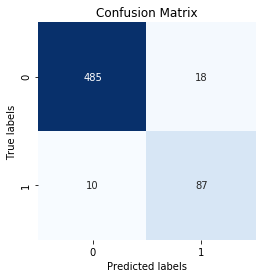

In [5]:
conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, square=True, annot=True, 
            cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels');
plt.ylabel('True labels');